# Setup

In [2]:
import numpy as np
from numpy import linalg as LA
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal, fft
import math as math
import os
from matplotlib.patches import Polygon
import copy
import pickle
from scipy.stats import norm,wilcoxon,shapiro,ttest_rel
import statistics

In [3]:
# plotting parameters
#determine colors and font size|
colors = dict(M='#6600CC',
              F='#000000',
              B='#FFFFFF',
              H='#009900',
              r='#FDB119',
              u='#009900',
              u25='#BBF90F',
              u75='#006400',
              d='#FD6E19',
              #y='#0033FF',  #or 6600CC which is darker and I prefer 
              y='#6600CC',  #or 6600CC which is darker and I prefer 
              N='#0000CC',
              D='#CC0000',
              g='#B1B1B1', #grey
              first5='#B1B1B1',
              last5='#999999',
              BLUE = '#1f77b4',
              ORANGE = '#ff7f0e',
              GREEN = '#2ca02c',
              RED = '#d62728',
              PURPLE = '#9467bd',
              GOLD = '#FDB119') #default colors
              # D = dominant = right; N = nondominant = left

yfill = list(matplotlib.colors.to_rgba(colors['y']))
yfill[-1] = 0.3

ufill = list(matplotlib.colors.to_rgba(colors['u']))
ufill[-1] = 0.3

gfill = list(matplotlib.colors.to_rgba(colors['g']))
gfill[-1] = 0.3

rfill = list(matplotlib.colors.to_rgba(colors['r']))
rfill[-1] = 0.3

bfill = list(matplotlib.colors.to_rgba(colors['BLUE']))
bfill[-1] = 0.3

font = {#'family' : 'normal',
        'weight' : 'ultralight',
        'size'   : 14}
matplotlib.rc('font', **font)
from matplotlib import rcParams
rcParams['axes.titlesize'] = 16
rcParams['font.weight'] = 'ultralight'
rcParams['font.family'] = 'sans-serif'
rcParams['mathtext.fontset'] = 'cm'

## analysis function

In [4]:
def mean_and_interquartile(data, axis = 0):
    """
    calculate mean and interquartile range of data.
    how to use: 
    mean, quantile25, quantile50, quantile75 = mean_and_interquartile(data, axis)
    """
    mean = np.nanmean(data, axis = axis)
    q25, q50, q75 = np.nanpercentile(data, [25, 50, 75], axis=axis)
    return mean, q25, q50, q75


def WilcoxonTest(all_data):
    """Wilcoxon signed-rank test:  
    tests the null hypothesis that two related paired samples come from the same distribution
    """

    n = len(all_data)
    w = np.zeros(n**2)
    p = np.zeros(n**2)
    sig = np.zeros(n**2)
    flag = []
    k = 0
    for i in range(n):
        for j in range(n):
            if i != j:
                w[k], p[k] = wilcoxon(all_data[i],all_data[j])
                # determine significant (p<=0.05)
                if p[k] <= 0.05:
                    sig[k] = 1
            else: 
                w[k] = np.nan
                p[k] = np.nan
                sig[k] = np.nan #i=j
            
            if sig[k] == 1 and j > i:
                flag.append('there is significant difference between condition '+str(i)+' and condition '+str(j)+', w = '+str(w[k])+ ', pvalue = '+str(p[k]))
            
            k+=1    
    return w,p,sig,flag

## load data

In [7]:
file_folder = "C:\\Users\\amber\\OneDrive - UW\\Sensorimotor Fusion\\pickles\\video_game_analysis\\" # laptop
# file_folder = "" # this folder

file_name = r'time_domain_data_HCPS101_115.pkl' # Amber's CPHS 15 subjects, time domain data
with open(file_folder + file_name, 'rb') as f:
    DATA = pickle.load(f)

file_name = r'time_domain_data_HCPS116_122.pkl' # 7 subject linearity test
with open(file_folder + file_name, 'rb') as f:
    DATA_L = pickle.load(f)

In [8]:
print(DATA.keys())
print(DATA_L.keys())

dict_keys(['subject0', 'subject1', 'subject2', 'subject3', 'subject4', 'subject5', 'subject6', 'subject7', 'subject8', 'subject9', 'subject10', 'subject11', 'subject12', 'subject13', 'subject14'])
dict_keys(['subject0', 'subject1', 'subject2', 'subject3', 'subject4', 'subject5', 'subject6'])


In [9]:
DATA['subject0'].keys()

# condition0: slider only
# condition1: EMG only

dict_keys(['condition0', 'condition1', 'condition2', 'condition3', 'condition4', 'condition5', 'condition6'])

In [10]:
DATA_L['subject0'].keys()

# condition0: slider only
# condition1: EMG only

dict_keys(['condition0', 'condition1', 'condition2', 'condition3', 'condition4'])

In [11]:
DATA['subject0']['condition0'].keys()

# r = reference position
# d = disturbance
# y = cursor position
# u = emg input

dict_keys(['Md', 'r', 'y', 'd', 'Wr', 'u', 'u0', 'u1'])

In [12]:
subject_num = len(DATA)
print(subject_num)

condition_num = 2 # here we only look at the first 2 conditions

trial_num = len(DATA['subject0']['condition0']['r'])
print(trial_num)

15
10


In [13]:
fs = 60         # sampling rate (Hz)
t0 = 1/fs       # first time step
T = 40          # total duration (s)
time = np.arange(t0, t0+T, 1/fs) # timestamps
N = len(time)   # number of samples
print(time)
print(N)

[1.66666667e-02 3.33333333e-02 5.00000000e-02 ... 3.99666667e+01
 3.99833333e+01 4.00000000e+01]
2400


# Time domain task performance (15 subjects)

In [14]:
ref = np.zeros((subject_num, condition_num, trial_num, N))
dis = np.zeros((subject_num, condition_num, trial_num, N))
cursor = np.zeros((subject_num, condition_num, trial_num, N))
for iK in range(subject_num):
    ref[iK] = np.stack((np.asarray(DATA['subject'+str(iK)]['condition0']['r']),np.asarray(DATA['subject'+str(iK)]['condition1']['r'])))
    dis[iK] = np.stack((np.asarray(DATA['subject'+str(iK)]['condition0']['d']),np.asarray(DATA['subject'+str(iK)]['condition1']['d'])))
    cursor[iK] = np.stack((np.asarray(DATA['subject'+str(iK)]['condition0']['y']),np.asarray(DATA['subject'+str(iK)]['condition1']['y'])))

print(ref.shape) # subject x condition x trial x time

(15, 2, 10, 2400)


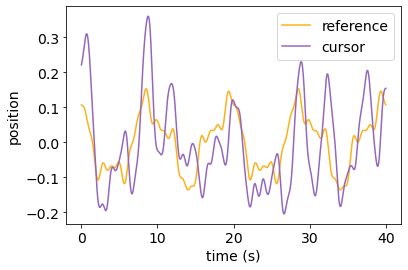

In [15]:
iK = 0 # subject
iC = 0 # condition
iT = -1 # trial
plt.plot(time, ref[iK,iC,iT,:], label='reference', color = colors['GOLD'])
plt.plot(time, cursor[iK,iC,iT,:], label='cursor', color = colors['PURPLE'])
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('position')
plt.legend()
plt.show()

## time domain task error

In [16]:
abs_error = np.abs(ref-cursor)
print(abs_error.shape)

(15, 2, 10, 2400)


No handles with labels found to put in legend.


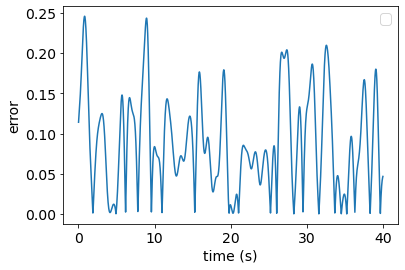

In [17]:
iK = 0 # subject
iC = 0 # condition
iT = -1 # trial
plt.plot(time, abs_error[iK,iC,iT,:])
plt.xlabel('time (s)')
plt.ylabel('error')
plt.legend()
plt.show()

## distribution of time domain error (avg of all trials)

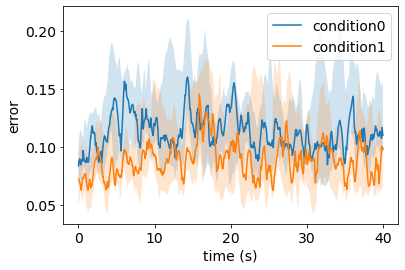

In [18]:
# average of all trials per subject

for iC in [0,1]: # condition
    data = np.mean(abs_error[:,iC,:,:], axis = 1) # average of all trials (15, 2400)
    mean, quantile25, quantile50, quantile75 = mean_and_interquartile(data, axis = 0) # distribution across subjects

    plt.plot(time, quantile50,label = 'condition'+str(iC)) # median, interquartiles
    plt.fill_between(time, quantile25, quantile75, alpha=0.2)
    plt.xlabel('time (s)')
    plt.ylabel('error')
plt.legend()
plt.show()   